In [24]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import ElasticNet

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

from keras.wrappers.scikit_learn import KerasRegressor

import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# # Path to ./data/processed folder
path_data_processed = os.path.join(
    os.path.abspath('../'),
    'data',
    'processed'
)

# Load Data

In [26]:
# Read dataset with AAPL's historic stock prices
df_stocks = pd.read_csv(
    os.path.join(
        path_data_processed,
        'stock_prices_appl.csv'
    ),
    index_col=0
)

# Apply pivot_table
df_stocks = df_stocks.pivot_table(
    values='Close',
    index='Date',
    columns='Stock'
).reset_index(drop=False)

In [27]:
# Read dataset with News' score
df_agg = pd.read_csv(
    os.path.join(
        path_data_processed,
        'analyst_ratings_avg_score_per_label.csv'
    )
)

# Fill NaN with 0, because there wasn't any news with this label
df_agg['positive'] = df_agg['positive'].fillna(0)
df_agg['negative'] = df_agg['negative'].fillna(0)
df_agg['neutral'] = df_agg['neutral'].fillna(0)

In [28]:
# Merge both dataframes on date
df = df_stocks.merge(df_agg, on='Date', how='left')

# Create target column by shifting stock prices
df[f'AAPL_target'] = df['AAPL'].shift(1)

# Data Preparation

In [29]:
# Select features
data = df.drop('Date', axis=1)

# Drop null values
data = data.dropna()

## Train-Test Split

In [30]:
# Set train percentage
train_percentage = 0.95

# Compute lenght of train dataframe
train_len = int(len(data) * train_percentage)

In [31]:
# Create data_train and data_test:
df_train = data.iloc[:train_len]
df_test = data.iloc[train_len:]

<Axes: xlabel='AAPL_target'>

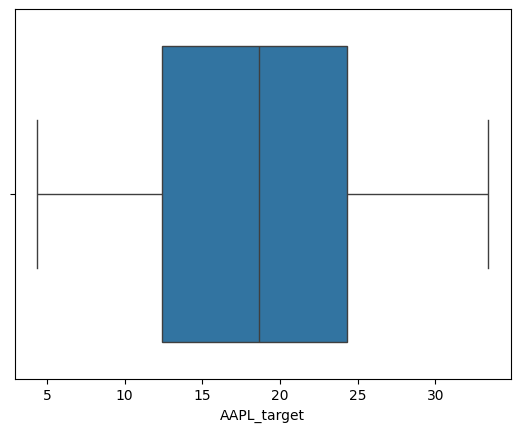

In [32]:
sns.boxplot(data=data, x='AAPL_target')

## Scaling
Transforming numerical features into a common smaller range

In [33]:
# Define features to be scaled
features_scale = ['AAPL']

# Define target columns
target = ['AAPL_target']

# Train MinMaxScaler to apply on the target columns
target_scaler = MinMaxScaler().fit(df_train[target])

# Apply scaler on train and test dataframes
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

# Train MinMaxScaler to apply on the feature columns
features_scaler = MinMaxScaler().fit(df_train[features_scale])

# Apply scaler on train and test dataframes
df_train[features_scale] = features_scaler.transform(df_train[features_scale])
df_test[features_scale] = features_scaler.transform(df_test[features_scale])

/tmp/ipykernel_410558/2582218321.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target] = target_scaler.transform(df_train[target])
/tmp/ipykernel_410558/2582218321.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target] = target_scaler.transform(df_test[target])
/tmp/ipykernel_410558/2582218321.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [34]:
# import pickle
# with open('aapl_with_hour_target_scaler_model_v4.pkl','wb') as f:
#     pickle.dump(target_scaler, f)

## Subsequences

In [35]:
# Define funtion to create subsequences
def subsequence(df, length, features, target):
    # Initialize variables
    X, y = [], []

    # Iterate over the dataframe to create subsequences
    for i in range(length, df.shape[0]):
        X.append(df[features].iloc[i - length: i])
        y.append(df[target].iloc[i])

    # Convert X and y into arrays
    X = np.array(X)
    y = np.expand_dims(
        np.array(y).astype(np.float32),
        axis=-1
    )

    return X, y

In [36]:
# Create subsequence with 5 business days X 4 weeks X 3 months
length = 5 * 4 * 3

features = [
    'AAPL',
    'negative',
    'neutral',
    'positive'
]

# Create train subsequences
X_train, y_train = subsequence(df_train, length, features, target)

# Create test subsequences
X_test, y_test = subsequence(df_test, length, features, target)

## Regularizer

In [37]:
# Reshape X_train
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Reshape y_train
y_train_reshaped = y_train.reshape(y_train.shape[0], -1)

# Reshape X_test
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [38]:
# Apply Elastic Net
# Define parameters
alpha = 0.1
l1_ratio = 0.5  # Ratio of L1 to L2 penalty (0.5 means equal penalties)

# Create Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ('elasticnet', ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
])

# Apply .fit
pipe.fit(X_train_reshaped, y_train_reshaped)

# Apply redict
y_pred = pipe.predict(X_test_reshaped)

/home/nathalia/.pyenv/versions/3.10.6/envs/stocks_vs_behavior/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e-01, tolerance: 7.310e-02
  model = cd_fast.enet_coordinate_descent(


# RNN Model

In [39]:
# Padding train and test
X_train_pad = pad_sequences(X_train, value=-999, padding='post', dtype='float64')
X_test_pad = pad_sequences(X_test, value=-999, padding='post', dtype='float64')

In [40]:
# Build the model
def rnn_model(rate):
    model = Sequential()

    model.add(layers.Masking(mask_value=-999))

    model.add(
        layers.GRU(
            units=128,
            return_sequences=True,
            activation="tanh",
            input_shape=X_train_pad[0].shape
        )
    )

    model.add(
        layers.GRU(
            units=64,
            return_sequences=False,
            activation="tanh"
        )
    )

    model.add(layers.Dropout(rate=rate))

    model.add(layers.Dense(25, activation="relu"))

    model.add(layers.Dense(1, activation="relu"))

    model.add(layers.Dropout(rate=rate))

    my_mae = metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None)

    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=[my_mae]
    )

    return model

model = rnn_model(rate=0.15)

# .fit

In [41]:
es = EarlyStopping(patience = 25, monitor = "val_mean_absolute_error")

history = model.fit(
    X_train_pad,
    np.array(y_train),
    validation_split = 0.25,
    batch_size=16,
    epochs=300,
    verbose = 1,
    callbacks = [es]
)

Epoch 1/300
533/533 [==============================] - 92s 149ms/step - loss: 0.0259 - mean_absolute_error: 0.0779 - val_loss: 0.0228 - val_mean_absolute_error: 0.1495
Epoch 2/300
533/533 [==============================] - 78s 146ms/step - loss: 0.0252 - mean_absolute_error: 0.0680 - val_loss: 0.0264 - val_mean_absolute_error: 0.1611
Epoch 3/300
533/533 [==============================] - 75s 141ms/step - loss: 0.0247 - mean_absolute_error: 0.0657 - val_loss: 0.0219 - val_mean_absolute_error: 0.1466
Epoch 4/300
533/533 [==============================] - 73s 137ms/step - loss: 0.0248 - mean_absolute_error: 0.0641 - val_loss: 0.0280 - val_mean_absolute_error: 0.1656
Epoch 5/300
533/533 [==============================] - 73s 137ms/step - loss: 0.0238 - mean_absolute_error: 0.0623 - val_loss: 0.0223 - val_mean_absolute_error: 0.1481
Epoch 6/300
533/533 [==============================] - 76s 142ms/step - loss: 0.0245 - mean_absolute_error: 0.0628 - val_loss: 0.0257 - val_mean_absolute_error:

In [42]:
# model.save(
#     os.path.join(
#         os.path.abspath('../'),
#         'models',
#         'aapl_per_hour_model_with_gru_and_avg_score_per_label_v4.keras'
#     )
# )

### Results

In [43]:
for i in history.history.keys():
    value = np.mean(history.history[i])
    print(i, " = ", value)

loss  =  0.024848520888813903
mean_absolute_error  =  0.062079064681061676
val_loss  =  0.036023315973579884
val_mean_absolute_error  =  0.18588023047362054


In [44]:
y_pred = target_scaler.inverse_transform(model.predict(X_test))
y_test2 = y_test[:, 0, 0]

r2 = r2_score(np.expand_dims(y_test2, -1), model.predict(X_test))
r2

-9.990958213806152

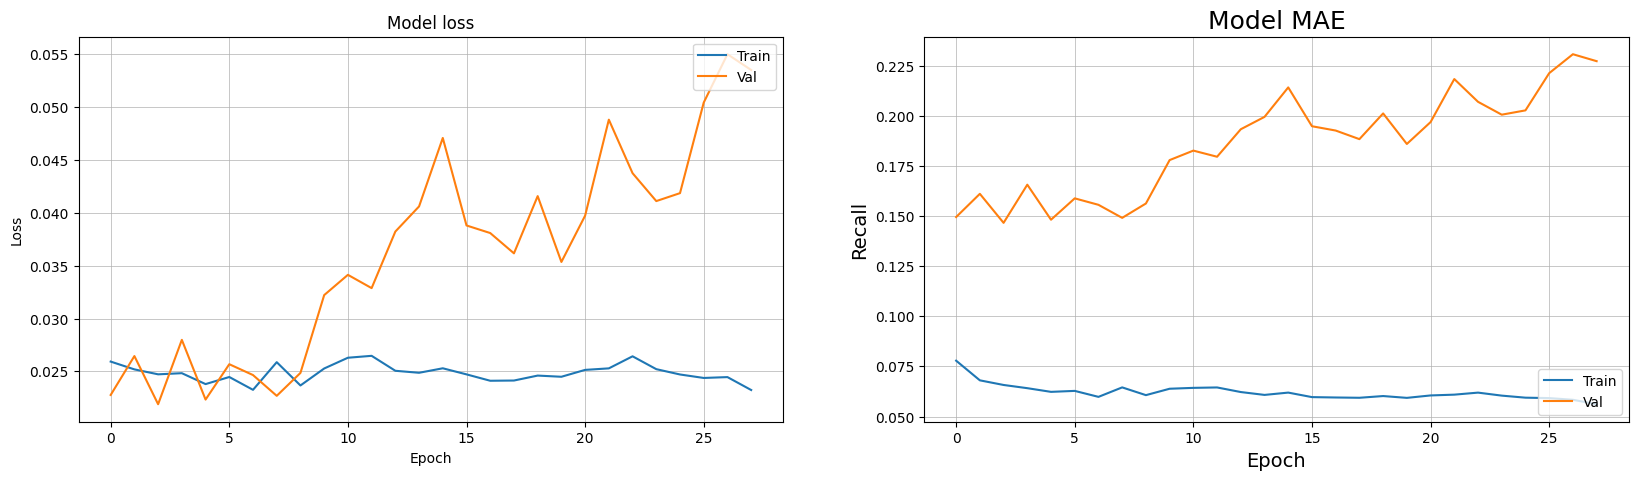

In [45]:
def plot_loss_mae(history):

    fig, ax =plt.subplots(1,2,figsize=(20,5))

    # --- LOSS

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- MAE

    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].plot(history.history['val_mean_absolute_error'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    plt.show()

plot_loss_mae(history)

## GridSearch - Dropout

In [ ]:
def custom_r2(y_true, y_pred):
    y_true = y_true.reshape((y_true.shape[0]))
    y_pred = y_pred.reshape((y_pred.shape[0]))
    return r2_score(y_true=y_true, y_pred=y_pred)

In [ ]:
model_keras = KerasRegressor(build_fn=rnn_model)

es = EarlyStopping(patience = 25, monitor = "val_mean_absolute_error")

grid = {
    'rate': [0.15, 0.3, 0.5],
}

search = GridSearchCV(
    model_keras,
    grid,
    # cv=3,
    scoring=make_scorer(custom_r2)
)

search_result  = search.fit(
    X_train_pad,
    y_train
    # np.array(y_train),
    batch_size=16,
    validation_split=0.25

)